<a href="https://colab.research.google.com/github/efeecllk/investor-sentiments/blob/main/lstm_bert_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
# Cell 2: Load and Preprocess Dataset

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/NLP/clean_tweet.csv')
df_label_0 = df[df['label'] == 0].sample(n=4000, random_state=42)
df_label_1 = df[df['label'] == 1].sample(n=4000, random_state=42)
df_label_2 = df[df['label'] == 2].sample(n=4000, random_state=42)

df = pd.concat([df_label_0, df_label_1, df_label_2]).reset_index(drop=True)

# Kontrol için label dağılımını göster
print(df['label'].value_counts())

# Check dataset
print(df.head())

# Preprocessing function
def preprocess_text(text):

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply preprocessing
df['clean_text'] = df['text_v'].apply(preprocess_text)

# Encode sentiment labels
label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['label'])  # 0: Neutral, 1: Bullish, 2: Bearish

# Train-test split
X = df['clean_text']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("✅ Dataset is ready for modeling!")


label
0    4000
1    4000
2    4000
Name: count, dtype: int64
                                              text_v  label
0  financial expert predict steady increase value...      0
1  coin experiencing surge trading volume today c...      0
2  blackrock announces dividend payment dividend ...      0
3  investor urged exercise caution face market fl...      0
4  financial technology fintech rapidly transform...      0
✅ Dataset is ready for modeling!


In [13]:
# Cell 3: Tokenization and Padding

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_length = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

vocab_size = len(tokenizer.word_index) + 1

print(f"✅ Vocabulary Size: {vocab_size}")
print(f"✅ Training data shape: {X_train_pad.shape}")


✅ Vocabulary Size: 9803
✅ Training data shape: (9600, 50)


In [14]:
# Cell 4: Build LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Cell 5: Train LSTM Model

history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    verbose=1
)


Epoch 1/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.3246 - loss: 1.1011 - val_accuracy: 0.3411 - val_loss: 1.1011
Epoch 2/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.3337 - loss: 1.1006 - val_accuracy: 0.3297 - val_loss: 1.0989
Epoch 3/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 43s 143ms/step - accuracy: 0.3896 - loss: 1.0517 - val_accuracy: 0.7255 - val_loss: 0.6652
Epoch 4/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - accuracy: 0.7980 - loss: 0.5241 - val_accuracy: 0.8172 - val_loss: 0.4756
Epoch 5/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - accuracy: 0.9208 - loss: 0.2409 - val_accuracy: 0.7802 - val_loss: 0.6025


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7951 - loss: 0.5378
LSTM Test Accuracy: 0.79


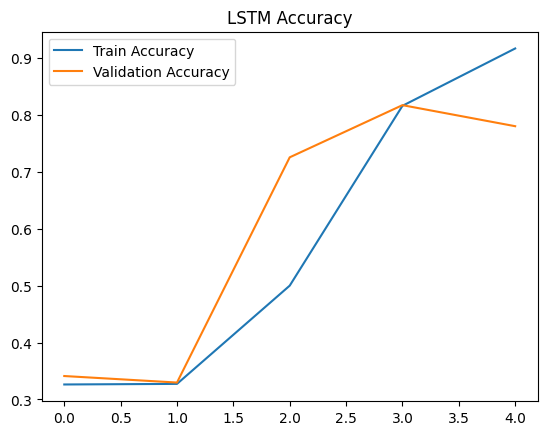

In [16]:

loss, accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f"LSTM Test Accuracy: {accuracy:.2f}")

# Plot accuracy
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.legend()
plt.show()


In [21]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from datasets import Dataset
import torch

# Tokenizer ve Model Yükleme
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
!pip install transformers datasets mlflow wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
from datasets import Dataset
# Pandas DataFrame'i HuggingFace Dataset'e dönüştür
dataset = Dataset.from_pandas(df)

# Tokenizasyon Fonksiyonu
def tokenize_function(examples):
    return tokenizer(examples['text_v'], padding='max_length', truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [29]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',  # Evaluation at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    gradient_accumulation_steps=2,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    save_strategy='epoch'  # Changed save strategy to match evaluation strategy
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [30]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,  # Validation dataset'iniz varsa belirtin
)


In [33]:
import mlflow
import mlflow.pytorch

# Check if an active run exists and end it if necessary
if mlflow.active_run():
    mlflow.end_run()

# MLflow Deneyimini Başlat
mlflow.start_run()

# Parametreleri Kaydet
mlflow.log_param("model_name", "distilbert-base-uncased")
mlflow.log_param("epochs", 3)
mlflow.log_param("batch_size", 16)

# Eğitimi Başlat
trainer.train()

# Metri̇kleri̇ Kaydet
eval_results = trainer.evaluate()
mlflow.log_metric("eval_loss", eval_results['eval_loss'])
mlflow.log_metric("eval_accuracy", eval_results['eval_accuracy'])

# Modeli Kaydet
mlflow.pytorch.log_model(model, "bert_model")

# MLflow Run'u Bitir
mlflow.end_run()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
model.save_pretrained("/content/drive/MyDrive/NLP/distilbert_model")
tokenizer.save_pretrained("/content/drive/MyDrive/NLP/distilbert_tokenizer")
lstm_model.save('/content/drive/MyDrive/NLP/lstm_model.h5')


In [ ]:
# Compare Model Performances
results = {
    'LSTM': lstm_model.evaluate(X_test_pad, y_test)[1],
    'BERT': accuracy,
}
print(results)
